##Initializing 

In [1]:
# Import libraries
!pip install gdown==4.3.0
import gdown
from IPython.display import clear_output
from scipy.io import loadmat, savemat
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.utils import class_weight
import collections
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
# GradCam
import cv2
# Augment function
from random import choice
import scipy.ndimage as ndi
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

## Check gpu availability
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#    raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

## Functions for augmentation

In [3]:
def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):

    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=3,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

# Random shift
def random_shift(img, wrg=0.2, hrg=0.2, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):

    h, w = img.shape[row_axis], img.shape[col_axis]
    tx = np.random.uniform(-hrg, hrg) * h
    ty = np.random.uniform(-wrg, wrg) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix
    img = apply_transform(img, transform_matrix, channel_axis, fill_mode, cval)
    return img

# Random zoom
def random_zoom(img, zoom_range=(0.88, 1.12), row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):

    if len(zoom_range) != 2:
        raise ValueError('`zoom_range` should be a tuple or list of two floats. '
                         'Received arg: ', zoom_range)

    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])

    h, w = img.shape[row_axis], img.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
    img = apply_transform(img, transform_matrix, channel_axis, fill_mode, cval)
    return img

# Elastic transform
def elastic_deform(img, alpha=0.2, sigma=0.08, random_state=None):

    if random_state is None:
        random_state = np.random.RandomState(None)
    else:
        random_state = np.random.RandomState(random_state)

    shape = img.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(img, indices, order=1, mode='reflect')
    return distored_image.reshape(img.shape)

#### BEHZAD: We can have mirror around lateral axis (left to right but not front to back)
def mirror_lateral(img, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):

    h, w = img.shape[row_axis], img.shape[col_axis]
    translation_matrix = np.array([[1, 0, 0],
                                   [0, -1, 0],
                                   [0, 0, 1]])

    transform_matrix = transform_matrix_offset_center(translation_matrix, h, w)
    img = apply_transform(img, transform_matrix, channel_axis, fill_mode, cval)
    return img


# FillMode = 'constant', 'nearest', 'reflect', 'wrap'
fns = [random_shift, random_zoom, elastic_deform] # Based on the reviewer comments we removed "mirror_lateral"

## Data preparation

In [4]:
# Download Data
#Links = {
#    'data.mat' : '1yXvY1u2Pbqsv2joCljf6zHc53AxEY7su', 
#}
# New data 
Links = {
    #'data.mat' : '1T1cNIAtPGGMfFWXmPzJ-sZJeyGbNmu2r', 
     'data.mat'  :  '1mP7t9TlT1F4854PPV3FLgirI_XbMP1VK', # Primary dataset from openneuro
     #'data.mat' : '1CsXodGAjq28zU2UMVrG5jC_pZJocvEZC', # Secondary dataset from OSF, this gives out of memory!!!!
    }

for Item in Links:
  url = f'https://drive.google.com/uc?id={Links[Item]}'
  gdown.download(url, Item, quiet=False)
  clear_output(wait=True)
print('The download was successful')

The download was successful


In [5]:
# Read data

Data = loadmat('data.mat')

Images = np.array([Data['dat'][0, 0]['Image'][0, Item] for Item in range(len(Data['dat'][0, 0]['Image'][0]))]).astype('float32')
Images = np.nan_to_num(Images)
Labels = [Data['dat'][0, 0]['Lable'][0, Item][0] for Item in range(len(Data['dat'][0, 0]['Lable'][0]))]
FileNames = [Data['dat'][0, 0]['file'][0, Item][0] for Item in range(len(Data['dat'][0, 0]['file'][0]))]

del Data

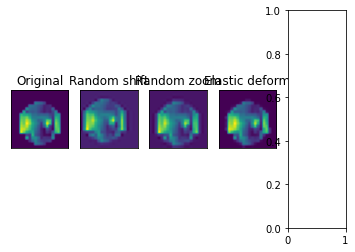

In [6]:
index = 5002
fig, axs = plt.subplots(1,5)
axs[0].imshow(Images[index][:, :, 10]) 
axs[0].set_yticks([])
axs[0].set_xticks([]) 
axs[0].set_title('Original')

tmp = random_shift(Images[index])
axs[1].imshow(tmp[:,:,10])
axs[1].set_yticks([])
axs[1].set_xticks([])
axs[1].set_title('Random shift')

tmp = random_zoom(Images[index])
axs[2].imshow(tmp[:,:,10])
axs[2].set_yticks([])
axs[2].set_xticks([])
axs[2].set_title('Random zoom')


tmp = elastic_deform(Images[index])
axs[3].imshow(tmp[:,:,10])
axs[3].set_yticks([])
axs[3].set_xticks([])
axs[3].set_title('Elastic deform')


plt.savefig('Augmentation.png', dpi=300)
plt.savefig('Augmentation.svg')

In [7]:
# Label encoding
y = preprocessing.LabelEncoder()
y.fit(Labels)
y = y.transform(Labels)

In [8]:
print(collections.Counter(Labels))
print(collections.Counter(y))

Counter({'pd_on': 3120, 'pd_off': 3000, 'control': 2946})
Counter({2: 3120, 1: 3000, 0: 2946})


In [9]:
# Train/Test/Validation Set Splitting
x_train, x_rem, y_train_int, y_rem_int = train_test_split(Images, y, test_size=0.25, random_state=4, stratify=y) # increased test/validation from .15 to .25
x_valid, x_test, y_valid_int, y_test_int = train_test_split(x_rem, y_rem_int, test_size=0.5, random_state=4, stratify=y_rem_int)

del x_rem, y_rem_int, Images, Labels

In [10]:
# Define and quantify variables

DataShape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
n_classes = len(np.unique(y))
# n_classes = len(set(y))

batch_size = 25 # BEHZAD changed this from 50 to 25, to get more samples per batch  #2
dropout_rate = 0.5
epochs = 100     
learning_rate = 1e-4

tf.random.set_seed(123)

# GradCam
NewDataShape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

In [11]:
# Data augmentation

AugmentedData = np.zeros((len(x_train), DataShape[0], DataShape[1], DataShape[2]))
AugmentedDataY = []

for Index, (Item_X, Item_Y) in enumerate(zip(x_train, y_train_int)):
  AugmentedData[Index, :, :, :] = choice(fns)(Item_X)
  AugmentedDataY.append(Item_Y)

AugmentedDataY = np.array(AugmentedDataY)

x_train = np.concatenate((x_train, AugmentedData), axis=0)
y_train_int = np.concatenate((y_train_int, AugmentedDataY), axis=0)

del AugmentedDataY

In [12]:
# Adding class weights

class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.unique(y_train_int),
                                                  y = y_train_int)

class_weights = dict(zip(np.unique(y_train_int), class_weights)),

print(class_weights)

({0: 1.0259544288516673, 1: 1.0072592592592593, 2: 0.9685185185185186},)


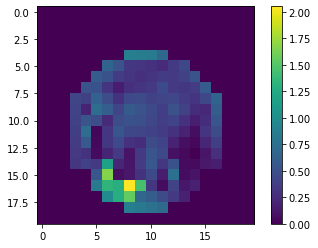

In [13]:
plt.imshow(x_train[5000][:, :, 10])
plt.colorbar()
plt.show()

In [14]:
print(x_train.shape)
print(collections.Counter(y_train_int))
print(x_valid.shape)
print(collections.Counter(y_valid_int))
print(x_test.shape)
print(collections.Counter(y_test_int))

(13598, 20, 20, 50)
Counter({2: 4680, 1: 4500, 0: 4418})
(1133, 20, 20, 50)
Counter({2: 390, 1: 375, 0: 368})
(1134, 20, 20, 50)
Counter({2: 390, 1: 375, 0: 369})


In [15]:
def spatial_zscore(X): # BEHZAD added this but ended up not using it
  [s0,s1,s2,s3] = X.shape
  Xz =[]
  for i in range(s0):
    xmean = np.tile(np.nanmean(np.reshape(X[i],[s1*s2,s3]), axis = 0), [s1,s2,1]);
    xstd = np.tile(np.nanstd(np.reshape(X[i],[s1*s2,s3]), axis = 0),[s1,s2,1]);
    Xz.append((X[i]-xmean)/xstd)
  return Xz

In [16]:
# z-scoring to normalize the data # BEHZAD commented out this because resampled data to normal dist.

#x_mean = np.mean(np.concatenate((x_train, x_valid, x_test), axis = 0)) # BEHZAD chagned this to all three
#x_std = np.std(np.concatenate((x_train, x_valid, x_test), axis = 0)) # BEHZAD chagned this to all three
#x_train = (x_train - x_mean)/x_std
#x_valid = (x_valid - x_mean)/x_std
#x_test = (x_test - x_mean)/x_std

#del x_mean, x_std
# changed it to within sample z-scoring
#TRAIN
#x_train      = spatial_zscore(x_train)
# convert to ndarray
#x_train = np.asarray(x_train)
#VALID
#x_valid      = spatial_zscore(x_valid)
# convert to ndarray
#x_valid  = np.asarray(x_valid)
#TEST
#x_test       = spatial_zscore(x_test)
# convert to ndarray
#x_test = np.asarray(x_test)

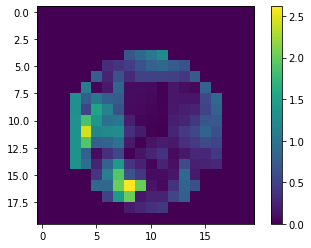

1


In [17]:
plt.imshow(x_train[304][:, :, 48])
plt.colorbar()
plt.show()
print(y_train_int[304])

## 3D convolutional neural network

In [18]:
y_train = keras.utils.to_categorical(y_train_int, num_classes=n_classes)
y_valid = keras.utils.to_categorical(y_valid_int, num_classes=n_classes)
y_test = keras.utils.to_categorical(y_test_int, num_classes=n_classes)

In [19]:
@tf.function

def train_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [20]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_valid))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the img is: (20, 20, 50, 1)


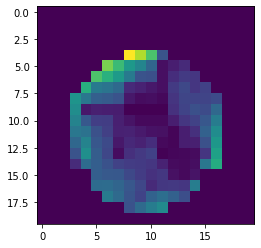

In [21]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the img is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]))

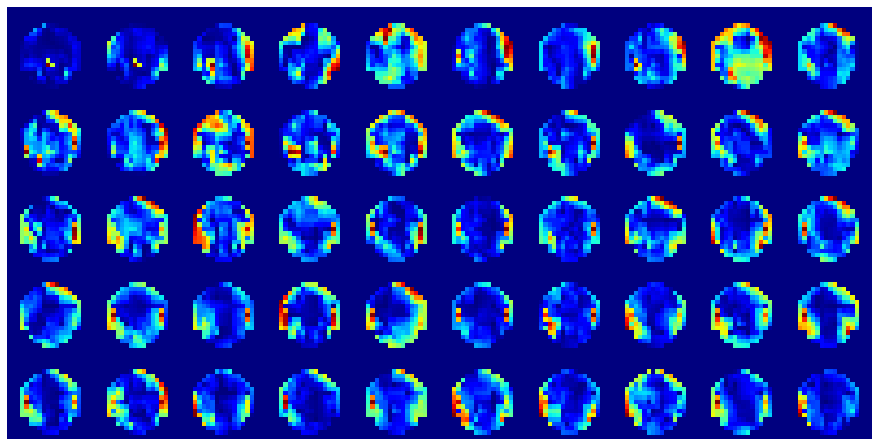

In [22]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="jet")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
plot_slices(5, 10, DataShape[0], DataShape[1], image[:, :, :50])

In [23]:
def get_model(width=DataShape[0], height=DataShape[1], depth=DataShape[2]):
  
  initializer = keras.initializers.GlorotNormal()
  # initializer = keras.initializers.GlorotUniform()

  inputs = keras.Input((width, height, depth, 1))

  x = keras.layers.Conv3D(filters=2, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same', activation="sigmoid", kernel_initializer=initializer, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-2), use_bias=True)(inputs)
  x = keras.layers.AveragePooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)

  x = keras.layers.Conv3D(filters=3, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same', activation="sigmoid", kernel_initializer=initializer, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-2), use_bias=True)(x)
  x = keras.layers.AveragePooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)

  x = keras.layers.Conv3D(filters=3, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same', activation="sigmoid", kernel_initializer=initializer, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-2), use_bias=True)(x)
  x = keras.layers.AveragePooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same')(x)
  
  x = keras.layers.BatchNormalization(scale=False, center=False)(x) #
  #x = keras.layers.GlobalMaxPooling3D()(x)
  
  # x = keras.layers.GlobalAveragePooling3D()(x)
  x = keras.layers.Flatten()(x)
  
  #x = keras.layers.Dense(units=3, activation="linear", kernel_initializer=initializer, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-3))(x)
  x = keras.layers.Dropout(dropout_rate)(x)
  x = keras.layers.ReLU()(x)
  # outputs = keras.layers.Dense(units=n_classes, activation="sigmoid")(x)
  # outputs = keras.layers.Dense(units=n_classes, activation="softmax", kernel_initializer=initializer)(x)
  outputs = keras.layers.Dense(units=n_classes, activation="softmax", kernel_initializer=initializer, kernel_regularizer = tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-2))(x)

  # Define the model.
  model = keras.Model(inputs, outputs, name="Parkinson3D")
  return model

In [24]:
# Build model.

model = get_model(width=DataShape[0], height=DataShape[1], depth=DataShape[2])
model.summary()

Model: "Parkinson3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 20, 50, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 20, 20, 50, 2)     56        
                                                                 
 average_pooling3d (AverageP  (None, 10, 10, 25, 2)    0         
 ooling3D)                                                       
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 10, 25, 3)     165       
                                                                 
 average_pooling3d_1 (Averag  (None, 5, 5, 13, 3)      0         
 ePooling3D)                                                     
                                                                 
 conv3d_2 (Conv3D)           (None, 5, 5, 13, 3)       

In [25]:
# Compile model.

# Optimizer
initial_learning_rate = learning_rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "Primary_data_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=25) # Changed patience from 15 to 25 based on the reviwers comment to reach more epochs

# Train the model, doing validation at the end of each epoch
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    class_weight=class_weights[0],
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
544/544 [==============================] - 17s 10ms/step - loss: 1.3218 - acc: 0.3300 - val_loss: 1.2055 - val_acc: 0.3310
Epoch 2/100
544/544 [==============================] - 6s 10ms/step - loss: 1.2243 - acc: 0.3372 - val_loss: 1.1874 - val_acc: 0.4237
Epoch 3/100
544/544 [==============================] - 5s 9ms/step - loss: 1.1931 - acc: 0.3461 - val_loss: 1.1752 - val_acc: 0.4863
Epoch 4/100
544/544 [==============================] - 5s 9ms/step - loss: 1.1754 - acc: 0.3595 - val_loss: 1.1621 - val_acc: 0.4475
Epoch 5/100
544/544 [==============================] - 5s 9ms/step - loss: 1.1593 - acc: 0.4023 - val_loss: 1.1491 - val_acc: 0.4748
Epoch 6/100
544/544 [==============================] - 5s 9ms/step - loss: 1.1448 - acc: 0.4211 - val_loss: 1.1342 - val_acc: 0.4872
Epoch 7/100
544/544 [==============================] - 5s 9ms/step - loss: 1.1326 - acc: 0.4380 - val_loss: 1.1236 - val_acc: 0.4934
Epoch 8/100
544/544 [==============================] - 5s 8ms/step

###### With data augmentation

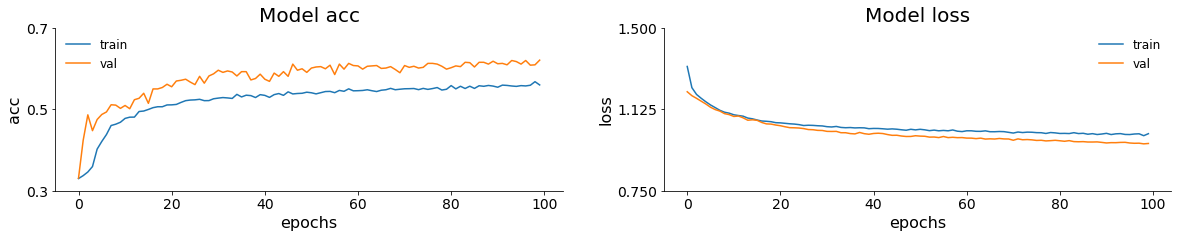

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
  ax[i].plot(history.history[metric])
  ax[i].plot(history.history["val_" + metric])
  ax[i].set_title("Model {}".format(metric))
  ax[i].set_xlabel("epochs")
  ax[i].set_ylabel(metric)
  ax[i].legend(["train", "val"], frameon=False, fontsize = 12)
  right_side = ax[i].spines["right"]
  right_side.set_visible(False)
  top_side = ax[i].spines["top"]
  top_side.set_visible(False)
  if i==0:
    ax[i].set_yticks(np.linspace(.3,.7,3))
    ax[i].set_ylim([.30, .70])
  else:
    ax[i].set_yticks(np.linspace(.75,1.5,3))
    ax[i].set_ylim([.75, 1.5])
  for item in ([ax[i].xaxis.label, ax[i].yaxis.label]):
    item.set_fontsize(16)
  for item in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
    item.set_fontsize(14)
  ax[i].title.set_fontsize(20)
  
plt.savefig("ACC.svg")

In [27]:
# Generate generalization metrics
# Validation
ValidationScores = model.evaluate(x_valid, y_valid, verbose=0)
print(f'Validation score: {model.metrics_names[0]} of {ValidationScores[0]}; {model.metrics_names[1]} of {ValidationScores[1]*100}%')
# Test
TestScores = model.evaluate(x_test, y_test, verbose=0)
print(f'Test score: {model.metrics_names[0]} of {TestScores[0]}; {model.metrics_names[1]} of {TestScores[1]*100}%')

Validation score: loss of 0.9676212072372437; acc of 62.04766035079956%
Test score: loss of 0.9844750165939331; acc of 59.34744477272034%
